# Email Data Preprocessing for Machine Learning

**Author:** Marco Antonio García Sánchez  
**Objective:** Demonstrate comprehensive data preprocessing techniques for email text data, preparing it for machine learning classification algorithms.  
**Dataset:** [TREC 2007 Public Spam Corpus](http://plg.uwaterloo.ca/~gvcormac/trec07/) – 75,419 emails labeled as spam or ham.

---

**Educational Use Only:** This notebook is developed for learning purposes as part of a Data Science portfolio. Original concepts adapted with proper attribution to academic sources.

**Original source / credit:**  
This notebook is based on the Udemy course: **"Machine Learning y Data Science: Curso Completo con Python"**  
URL: [udemy.com/course/machine-learning-desde-cero/learn/lecture/19203700](http://udemy.com/course/machine-learning-desde-cero/learn/lecture/19203700)

**Modifications and improvements:**  
- Reorganized sections for clarity and reproducibility.  
- Added **detailed Markdown documentation** in English.  
- Included **comprehensive preprocessing pipeline**: HTML tag removal, punctuation cleaning, stopwords removal, and stemming.  
- Implemented **text vectorization** using `CountVectorizer` for converting emails into numerical features.  
- Enhanced code structure and documentation for **GitHub repository presentation**.  
- Focused on **data preprocessing best practices** and techniques.

---

This notebook demonstrates **essential data preprocessing skills** for text classification projects, showing the complete transformation from raw email data to machine learning-ready numerical features.

**Integration with ML Projects:** The preprocessed data from this notebook will be used to demonstrate different classification methods using various machine learning algorithms in the Machine Learning section of this portfolio.

#### Dataset Selection

The objective of this project is to demonstrate **comprehensive data preprocessing techniques** for text classification using email data.  
For this purpose, the following dataset has been selected:

**2007 TREC Public Spam Corpus**

The `trec07p` corpus contains **75,419 messages**:  

- 25,220 HAM (legitimate emails)  
- 50,199 SPAM  

These messages represent all emails delivered to a particular server between the following dates:  

- Sun, 8 Apr 2007 13:07:21 -0400  
- Fri, 6 Jul 2007 07:04:53 -0400  

This dataset serves as an excellent example for demonstrating **text preprocessing techniques**, including HTML parsing, text cleaning, tokenization, and vectorization for machine learning applications.

## 1.- Environment & Libraries

#### Python Environment Setup
To ensure reproducibility and avoid conflicts between Python packages, it is recommended to use a **virtual environment** for each project.  
This way, you can create, manage, and delete environments without affecting your main Python installation.

#### Steps to create a virtual environment (optional but recommended):
```bash
# Create a virtual environment named 'ml_env'
python -m venv ml_env

# Activate the environment (Windows)
ml_env\Scripts\activate

# Activate the environment (macOS/Linux)
source ml_env/bin/activate

# After finishing the project, you can deactivate it
deactivate

# If you want to remove the environment completely, just delete the folder
rm -rf ml_env

## 2.- Data Cleaning

#### Cleaning HTML data

In this practical case related to SPAM email detection, the dataset consists of emails with their corresponding headers and additional fields. Therefore, the data requires **preprocessing** before being fed into the Machine Learning algorithm.

In [1]:
# ------------------------------------------------------------
# This class facilitates preprocessing of emails containing HTML code.
# It extracts only the text content, removing all HTML tags.
# ------------------------------------------------------------

from html.parser import HTMLParser

class MLStripper(HTMLParser):
    "MLStripper is a helper class for cleaning HTML content in emails.It inherits from Python's built-in HTMLParser."
    def __init__(self):
        super().__init__()
        self.strict = False          # Do not raise errors on malformed HTML
        self.convert_charrefs = True # Convert HTML character references automatically
        self.fed = []                # List to store text segments

    def handle_data(self, d):
        "This method is called for each chunk of text found inside HTML.It appends the text to the fed list."
        self.fed.append(d)

    def get_data(self):
        "Joins all text segments and returns the cleaned text."
        return ''.join(self.fed)

In [2]:
# ------------------------------------------------------------
# This function removes HTML tags from the text of an email.
# It uses the MLStripper class defined above to extract only the text content.
# ------------------------------------------------------------
def strip_tags(html):
    """
    Remove HTML tags from a given HTML string.
    Parameters:
    -----------
    html : str
        The HTML content to be cleaned.
    Returns:
    --------
    str
        Cleaned text with all HTML tags removed.
    Usage:
    ------
    clean_text = strip_tags(email_html_content)
    """
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
# Example of removing HTML tags from a more realistic email content
email_html = """
<html>
  <head><title>Special Offer!</title></head>
  <body>
    <h1>Congratulations!</h1>
    <p>Dear user,</p>
    <p>You have been selected to receive a <b>50% discount</b> on our premium plan.</p>
    <p>Click <a href="https://www.example.com/redeem">here</a> to claim your offer.</p>
    <footer>
      <p>Contact us at support@example.com</p>
      <p>&copy; 2025 Example Corp.</p>
    </footer>
  </body>
</html>
"""

# Clean the HTML using the strip_tags function
clean_text = strip_tags(email_html)
print(clean_text)



  Special Offer!
  
    Congratulations!
    Dear user,
    You have been selected to receive a 50% discount on our premium plan.
    Click here to claim your offer.
    
      Contact us at support@example.com
      © 2025 Example Corp.
    
  




#### Cleaning and reduce noise

In addition to removing possible HTML tags from emails, several other preprocessing steps are necessary to reduce noise in the messages. These steps include:

- **Removing punctuation** to clean the text from unnecessary symbols.  
- **Discarding irrelevant email fields** that do not contribute useful information.  
- **Stemming**: reducing words to their root form by removing affixes.  

The following class implements these transformations, preparing the email content for Machine Learning algorithms.

In [9]:

import nltk
nltk.download('stopwords')

class Parser:
    """
    Preprocess emails: remove HTML, punctuation, stopwords, and apply stemming.
    """

    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = list(string.punctuation)

    def parse(self, email_path):
        """Parse email file and return content as dict."""
        with open(email_path, errors='ignore') as e:
            msg = email.message_from_file(e)
        return None if not msg else self.get_email_content(msg)

    def get_email_content(self, msg):
        """Extract subject, body, and content type from email."""
        subject = self.tokenize(msg['Subject']) if msg['Subject'] else []
        body = self.get_email_body(msg.get_payload(), msg.get_content_type())
        content_type = msg.get_content_type()
        return {"subject": subject, "body": body, "content_type": content_type}

    def get_email_body(self, payload, content_type):
        """Extract and preprocess email body."""
        body = []
        if type(payload) is str and content_type == 'text/plain':
            return self.tokenize(payload)
        elif type(payload) is str and content_type == 'text/html':
            return self.tokenize(strip_tags(payload))
        elif type(payload) is list:
            for p in payload:
                body += self.get_email_body(p.get_payload(), p.get_content_type())
        return body

    def tokenize(self, text):
        """Clean text: remove punctuation, stopwords, and apply stemming."""
        for c in self.punctuation:
            text = text.replace(c, "")
        text = text.replace("\t", " ").replace("\n", " ")
        tokens = list(filter(None, text.split(" ")))
        return [self.stemmer.stem(w) for w in tokens if w not in self.stopwords]

[nltk_data] Downloading package stopwords to /Users/marco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Reading and Preprocessing a Single Email

In the following cells, we:
1. Read the raw content of an individual email from the dataset (`inmail.1`).
2. Process it with the `Parser()` class to extract only the relevant words.

Printing the entire raw email is optional, but it is a useful **visual tool** to see what the functions are doing and how the email content looks before cleaning.

The goal of the parser is to keep only the **meaningful words** in the message (e.g., "free", "money", "offer") and remove uninformative words such as articles (*the, a, an, el, los*) and other stopwords.  
This reduces noise and makes the model focus on the truly discriminative features when classifying emails as spam or ham.

In [10]:
# Read the content of a specific email
# (Optional: this step helps visualize the raw structure of an email before cleaning)
import string
inmail = open("/Users/marco/Desktop/GitRepositorios/Datasets/trec07p/data/inmail.1").read()
print(inmail)

From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007
Return-Path: <RickyAmes@aol.com>
Received: from 129.97.78.23 ([211.202.101.74])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;
	Sun, 8 Apr 2007 13:07:21 -0400
Received: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100
Message-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>
From: "Tomas Jacobs" <RickyAmes@aol.com>
Reply-To: "Tomas Jacobs" <RickyAmes@aol.com>
To: the00@speedy.uwaterloo.ca
Subject: Generic Cialis, branded quality@ 
Date: Sun, 08 Apr 2007 21:00:48 +0300
X-Mailer: Microsoft Outlook Express 6.00.2600.0000
MIME-Version: 1.0
Content-Type: multipart/alternative;
	boundary="--8896484051606557286"
X-Priority: 3
X-MSMail-Priority: Normal
Status: RO
Content-Length: 988
Lines: 24

----8896484051606557286
Content-Type: text/html;
Content-Transfer-Encoding: 7Bit

<html>
<body bgcolor="#ffffff">
<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0px; margin-bottom: 0px;" align="

In [12]:
# Process the email with Parser to extract only the cleaned and relevant words
# Stopwords and unimportant tokens are removed so the model can focus on meaningful content
import email
p = Parser()
p.parse("/Users/marco/Desktop/GitRepositorios/Datasets/trec07p/data/inmail.1")

{'subject': ['gener', 'ciali', 'brand', 'qualiti'],
 'body': ['do',
  'feel',
  'pressur',
  'perform',
  'rise',
  'occas',
  'tri',
  'viagra',
  'anxieti',
  'thing',
  'past',
  'back',
  'old',
  'self'],
 'content_type': 'multipart/alternative'}

#### Procesamiento del archivo `index`  

In this section:  
1. We read the `index` file, which contains the list of all emails in the dataset along with their label (spam or ham).  
2. We define the function `parse_index()` that extracts:  
   - The **label** of the email (spam or ham).  
   - The **file path** of the corresponding email.  
   This is returned as a list of dictionaries for easier handling.  
3. We define the function `parse_email()` that takes one index entry, opens the email, and processes it with the `Parser` to obtain only the relevant words along with its label.  

This step is essential because it gives us a clean representation of each email: its filtered content and its category (spam or ham).  

In [13]:
index = open("/Users/marco/Desktop/GitRepositorios/Datasets/trec07p/full/index").readlines()
index[0:3]

['spam ../data/inmail.1\n',
 'ham ../data/inmail.2\n',
 'spam ../data/inmail.3\n']

In [15]:
import os
DATASET_PATH = os.path.join("/Users/marco/Desktop/GitRepositorios/datasets", "trec07p")

def parse_index(path_to_index, n_elements):
    ret_indexes = []
    index = open(path_to_index).readlines()
    for i in range(n_elements):
        mail = index[i].split(" ../")
        label = mail[0]
        path = mail[1][:-1]
        path_mail = path.split("/")[-1]
        ret_indexes.append({"label":label, "email_path":os.path.join(DATASET_PATH, os.path.join("data", path_mail))})
    return ret_indexes

In [16]:
def parse_email(index):
    p = Parser()
    pmail = p.parse(index["email_path"])
    return pmail, index["label"]

In [17]:
indexes = parse_index("/Users/marco/Desktop/GitRepositorios/datasets/trec07p/full/index", 3)
indexes

[{'label': 'spam',
  'email_path': '/Users/marco/Desktop/GitRepositorios/datasets/trec07p/data/inmail.1'},
 {'label': 'ham',
  'email_path': '/Users/marco/Desktop/GitRepositorios/datasets/trec07p/data/inmail.2'},
 {'label': 'spam',
  'email_path': '/Users/marco/Desktop/GitRepositorios/datasets/trec07p/data/inmail.3'}]


## 3.- Preprocess Show

English:
In this code block we demonstrate how we transform an email from raw text (strings)
into numerical representations that can be used by Machine Learning algorithms. 
The steps are:

1. Load the index and read one email from the dataset (spam or ham).
2. Process the email with parse_email to separate subject and body.
3. Convert the text into numerical representations in two different ways:
   a) Bag of Words with CountVectorizer (each word is treated as a feature).
4. Display the extracted features and their numerical values.

This shows how raw text is converted into structured data 
for use in spam classification models.
"""

In [18]:
# Load the index and labels into memory (only one email for demonstration)
index = parse_index("/Users/marco/Desktop/GitRepositorios/datasets/trec07p/full/index", 1)
index

[{'label': 'spam',
  'email_path': '/Users/marco/Desktop/GitRepositorios/datasets/trec07p/data/inmail.1'}]

In [20]:
# Read the raw content of the first email
open(index[0]["email_path"]).read()

'From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007\nReturn-Path: <RickyAmes@aol.com>\nReceived: from 129.97.78.23 ([211.202.101.74])\n\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;\n\tSun, 8 Apr 2007 13:07:21 -0400\nReceived: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100\nMessage-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>\nFrom: "Tomas Jacobs" <RickyAmes@aol.com>\nReply-To: "Tomas Jacobs" <RickyAmes@aol.com>\nTo: the00@speedy.uwaterloo.ca\nSubject: Generic Cialis, branded quality@ \nDate: Sun, 08 Apr 2007 21:00:48 +0300\nX-Mailer: Microsoft Outlook Express 6.00.2600.0000\nMIME-Version: 1.0\nContent-Type: multipart/alternative;\n\tboundary="--8896484051606557286"\nX-Priority: 3\nX-MSMail-Priority: Normal\nStatus: RO\nContent-Length: 988\nLines: 24\n\n----8896484051606557286\nContent-Type: text/html;\nContent-Transfer-Encoding: 7Bit\n\n<html>\n<body bgcolor="#ffffff">\n<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0

In [21]:
# Parse the email into structured format (subject, body, and label)
mail, label = parse_email(index[0])
print("The email label is:", label)
print(mail)

The email label is: spam
{'subject': ['gener', 'ciali', 'brand', 'qualiti'], 'body': ['do', 'feel', 'pressur', 'perform', 'rise', 'occas', 'tri', 'viagra', 'anxieti', 'thing', 'past', 'back', 'old', 'self'], 'content_type': 'multipart/alternative'}


### CountVectorizer – Transforming Text into Numbers  

The **Logistic Regression algorithm cannot process raw text**. It needs numbers.  
To solve this, we use **`CountVectorizer`**, which converts emails into a numerical format.  

#### What CountVectorizer does  
1. **Tokenization** → Splits the email into individual words (*tokens*).  
   Example:  
   `"This email is spam"` → `[ "this", "email", "is", "spam" ]`  

2. **Builds a vocabulary** → Creates a dictionary of all unique words found in the text.  
   Example:  
   `{ "this": 0, "email": 1, "is": 2, "spam": 3 }`  

3. **Counts word occurrences** → For each email, counts how many times each word appears.  
   Example:  
   `"This email is spam spam"` → `[1, 1, 1, 2]`  
   *(“this” appears once, “email” once, “is” once, “spam” twice)*  

This is called a **Bag-of-Words representation**, because it ignores grammar and word order, but keeps the frequency of words.  

#### Why it matters  
- Logistic Regression works only with **numerical features**, so Bag-of-Words makes text usable.  
- Common, uninformative words (*“the”*, *“a”*, *“is”*, etc.) can be removed, since they don’t help classify spam vs ham (**stop-word removal**).  
- The result is a **document-term matrix**, which becomes the input for the machine learning model.  

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

# Prepare the email as a single string (subject + body combined)
prep_email = [" ".join(mail['subject']) + " ".join(mail['body'])]

# Transform text into a Bag-of-Words representation
vectorizer = CountVectorizer()
X = vectorizer.fit(prep_email)

print("Email:", prep_email, "\n")
print("Input features (vocabulary):", vectorizer.get_feature_names_out())

Email: ['gener ciali brand qualitido feel pressur perform rise occas tri viagra anxieti thing past back old self'] 

Input features (vocabulary): ['anxieti' 'back' 'brand' 'ciali' 'feel' 'gener' 'occas' 'old' 'past'
 'perform' 'pressur' 'qualitido' 'rise' 'self' 'thing' 'tri' 'viagra']


In [24]:
# Convert the preprocessed email into numerical vector form
X = vectorizer.transform(prep_email)
print("\nNumerical values:\n", X.toarray())


Numerical values:
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


### Function: `create_prep_dataset`

#### Description
Builds a dataset of emails ready for machine learning.  
Concatenates the subject and body of each email and associates it with its label (`spam` or `ham`).
#### Parameters
- `index_path` (str): Path to the dataset index file.  
- `n_elements` (int): Number of emails to process.  
#### Returns
- `X` (list of str): Full text of each email.  
- `y` (list of str): Corresponding labels (`spam` or `ham`).  
#### Notes
- Skips emails that cannot be parsed.  
- Useful for preparing raw emails before vectorization.

In [25]:
def create_prep_dataset(index_path, n_elements):
    X = []
    y = []
    indexes = parse_index(index_path, n_elements)
    for i in range(n_elements):
        print("\rParsing email: {0}".format(i+1), end='')
        try:
            mail, label = parse_email(indexes[i])
            X.append(" ".join(mail['subject']) + " ".join(mail['body']))
            y.append(label)
        except:
            pass
    return X, y

## 4.- Training Dataset Preparation

In this step, we prepare a subset of emails to train the machine learning model.  
- We read **1000 emails** from the dataset (you can adjust the number as needed).  
- The emails are preprocessed and transformed into a numerical format using the vectorizer.  
- Finally, we display the numerical feature matrix and the number of features for inspection.  
- Optionally, we convert it into a **Pandas DataFrame** for easier visualization and analysis.  


In [26]:
X_train, y_train = create_prep_dataset("/Users/marco/Desktop/GitRepositorios/datasets/trec07p/full/index", 1000)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)

Parsing email: 1000

In [28]:
pd.DataFrame(X_train.toarray(), columns=[vectorizer.get_feature_names_out()]).head(5)


,00,000,0000,000000,000002,000048000000000,000099,0000ff,000115000000000,0001171749,...,绰۹ϵͳctsƽ,肾ǝvă,鏗ėvłq,饻jwk,鵵χ,낢ȏglgwă,뵭袵,뼰ʱϵ,쫷ƹư,쵼ã
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6.- Exploratory Data Analysis (EDA)

After preprocessing the email data and creating the numerical feature matrix, it's essential to analyze the characteristics of our processed dataset. This analysis helps us understand:

- **Class distribution** in our dataset
- **Email length patterns** by category  
- **Most frequent words** that distinguish spam from ham
- **Matrix characteristics** for machine learning readiness

This exploratory analysis provides valuable insights before applying machine learning algorithms.


Spam: 783 emails (78.3%)
Ham: 217 emails (21.7%)


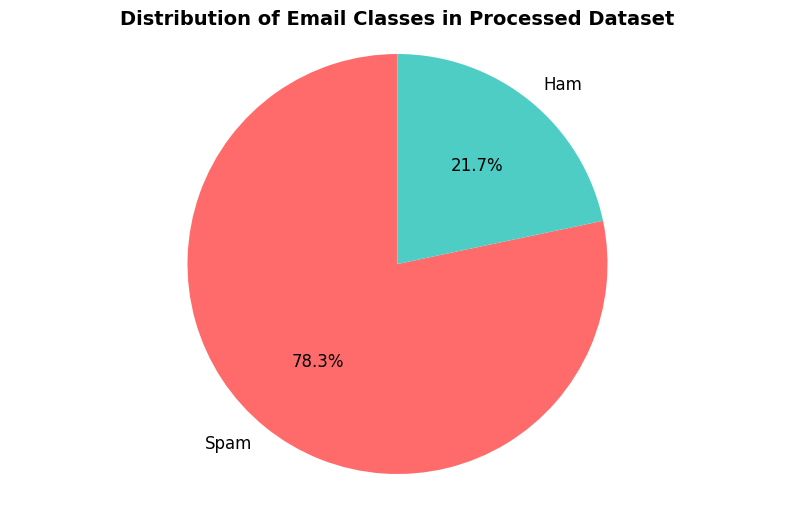

In [33]:
# DATASET ANALYSIS - CLASS DISTRIBUTION
import matplotlib.pyplot as plt
import numpy as np

# Distribution of email classes
plt.figure(figsize=(10, 6))
class_counts = pd.Series(y_train).value_counts()
colors = ['#ff6b6b', '#4ecdc4']  # Red for spam, Teal for ham
labels = ['Spam', 'Ham']

plt.pie(class_counts.values, labels=labels, autopct='%1.1f%%', 
        colors=colors, startangle=90, textprops={'fontsize': 12})
plt.title('Distribution of Email Classes in Processed Dataset', fontsize=14, fontweight='bold')
plt.axis('equal')

# Add count information
for i, (label, count) in enumerate(zip(labels, class_counts.values)):
    print(f"{label}: {count:,} emails ({count/len(y_train)*100:.1f}%)")

plt.show()


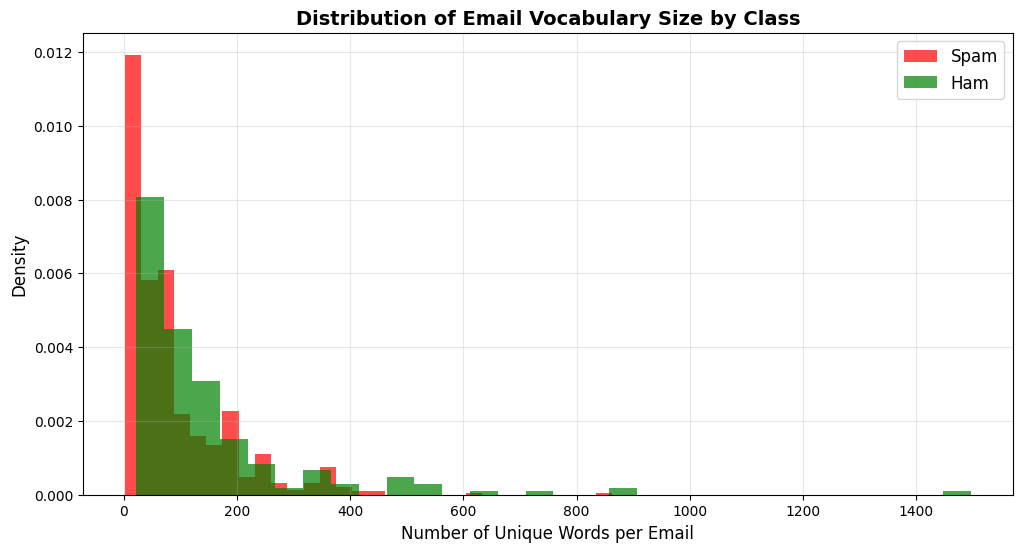

Average unique words in Spam emails: 88.9
Average unique words in Ham emails: 143.1
Spam emails tend to have fewer unique words on average


In [34]:
# EMAIL LENGTH ANALYSIS BY CLASS
# Calculate email lengths using non-zero elements as proxy for vocabulary size
email_lengths_spam = []
email_lengths_ham = []

# Analyze vocabulary size (non-zero elements) by class
for i, label in enumerate(y_train):
    word_count = X_train[i].nnz  # Number of non-zero elements (unique words present)
    if label == 'spam':
        email_lengths_spam.append(word_count)
    else:
        email_lengths_ham.append(word_count)

plt.figure(figsize=(12, 6))
plt.hist(email_lengths_spam, alpha=0.7, label='Spam', bins=30, color='red', density=True)
plt.hist(email_lengths_ham, alpha=0.7, label='Ham', bins=30, color='green', density=True)
plt.xlabel('Number of Unique Words per Email', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Distribution of Email Vocabulary Size by Class', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average unique words in Spam emails: {np.mean(email_lengths_spam):.1f}")
print(f"Average unique words in Ham emails: {np.mean(email_lengths_ham):.1f}")
print(f"Spam emails tend to have {'more' if np.mean(email_lengths_spam) > np.mean(email_lengths_ham) else 'fewer'} unique words on average")


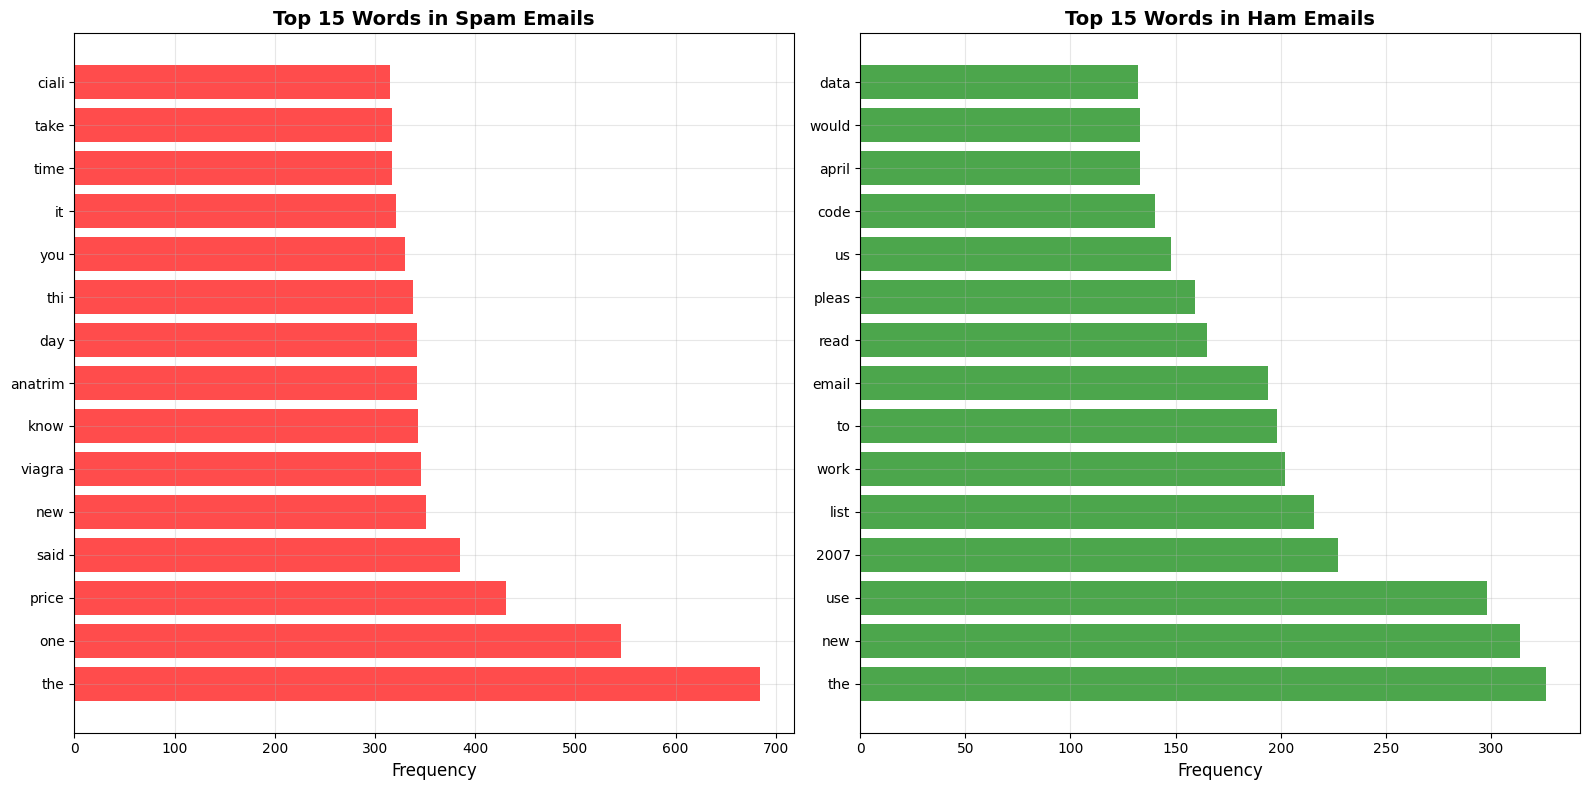

\n============================================================
WORD FREQUENCY INSIGHTS
\nTop Spam Words:
 1. the             (684 occurrences)
 2. one             (545 occurrences)
 3. price           (431 occurrences)
 4. said            (385 occurrences)
 5. new             (351 occurrences)
 6. viagra          (346 occurrences)
 7. know            (343 occurrences)
 8. anatrim         (342 occurrences)
 9. day             (342 occurrences)
10. thi             (338 occurrences)
\nTop Ham Words:
 1. the             (326 occurrences)
 2. new             (314 occurrences)
 3. use             (298 occurrences)
 4. 2007            (227 occurrences)
 5. list            (216 occurrences)
 6. work            (202 occurrences)
 7. to              (198 occurrences)
 8. email           (194 occurrences)
 9. read            (165 occurrences)
10. pleas           (159 occurrences)
\nSpam-specific words (not in top Ham words): 13
Ham-specific words (not in top Spam words): 13


In [35]:
# TOP WORDS ANALYSIS BY CLASS
from collections import Counter

def get_top_words_by_class(matrix, labels, target_label, feature_names, n=15):
    """
    Get most frequent words for a specific class using the vectorized matrix
    """
    # Get indices of emails belonging to target class
    target_indices = [i for i, label in enumerate(labels) if label == target_label]
    
    # Sum word frequencies for target class
    class_word_counts = matrix[target_indices].sum(axis=0).A1  # Convert to 1D array
    
    # Get top words with their counts
    top_indices = np.argsort(class_word_counts)[-n:][::-1]  # Top n, reversed for descending order
    top_words = [(feature_names[i], class_word_counts[i]) for i in top_indices if class_word_counts[i] > 0]
    
    return top_words

# Get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Get top words for each class
spam_words = get_top_words_by_class(X_train, y_train, 'spam', feature_names, n=15)
ham_words = get_top_words_by_class(X_train, y_train, 'ham', feature_names, n=15)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Spam words
spam_word_list = [word for word, _ in spam_words]
spam_counts = [count for _, count in spam_words]
ax1.barh(range(len(spam_word_list)), spam_counts, color='red', alpha=0.7)
ax1.set_yticks(range(len(spam_word_list)))
ax1.set_yticklabels(spam_word_list)
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_title('Top 15 Words in Spam Emails', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Ham words
ham_word_list = [word for word, _ in ham_words]
ham_counts = [count for _, count in ham_words]
ax2.barh(range(len(ham_word_list)), ham_counts, color='green', alpha=0.7)
ax2.set_yticks(range(len(ham_word_list)))
ax2.set_yticklabels(ham_word_list)
ax2.set_xlabel('Frequency', fontsize=12)
ax2.set_title('Top 15 Words in Ham Emails', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\\n" + "="*60)
print("WORD FREQUENCY INSIGHTS")
print("="*60)
print(f"\\nTop Spam Words:")
for i, (word, count) in enumerate(spam_words[:10], 1):
    print(f"{i:2d}. {word:<15} ({count} occurrences)")

print(f"\\nTop Ham Words:")
for i, (word, count) in enumerate(ham_words[:10], 1):
    print(f"{i:2d}. {word:<15} ({count} occurrences)")

# Find words that are distinctive to each class
spam_words_set = set(word for word, _ in spam_words)
ham_words_set = set(word for word, _ in ham_words)
spam_specific = spam_words_set - ham_words_set
ham_specific = ham_words_set - spam_words_set

print(f"\\nSpam-specific words (not in top Ham words): {len(spam_specific)}")
print(f"Ham-specific words (not in top Spam words): {len(ham_specific)}")


/var/folders/74/wvgnxc2125s079cm4vbx5txw0000gn/T/ipykernel_24456/23408886.py:18: RuntimeWarning: divide by zero encountered in divide
  discrimination_ratio = np.where(ham_counts > 0, spam_counts / ham_counts, spam_counts * 1000)


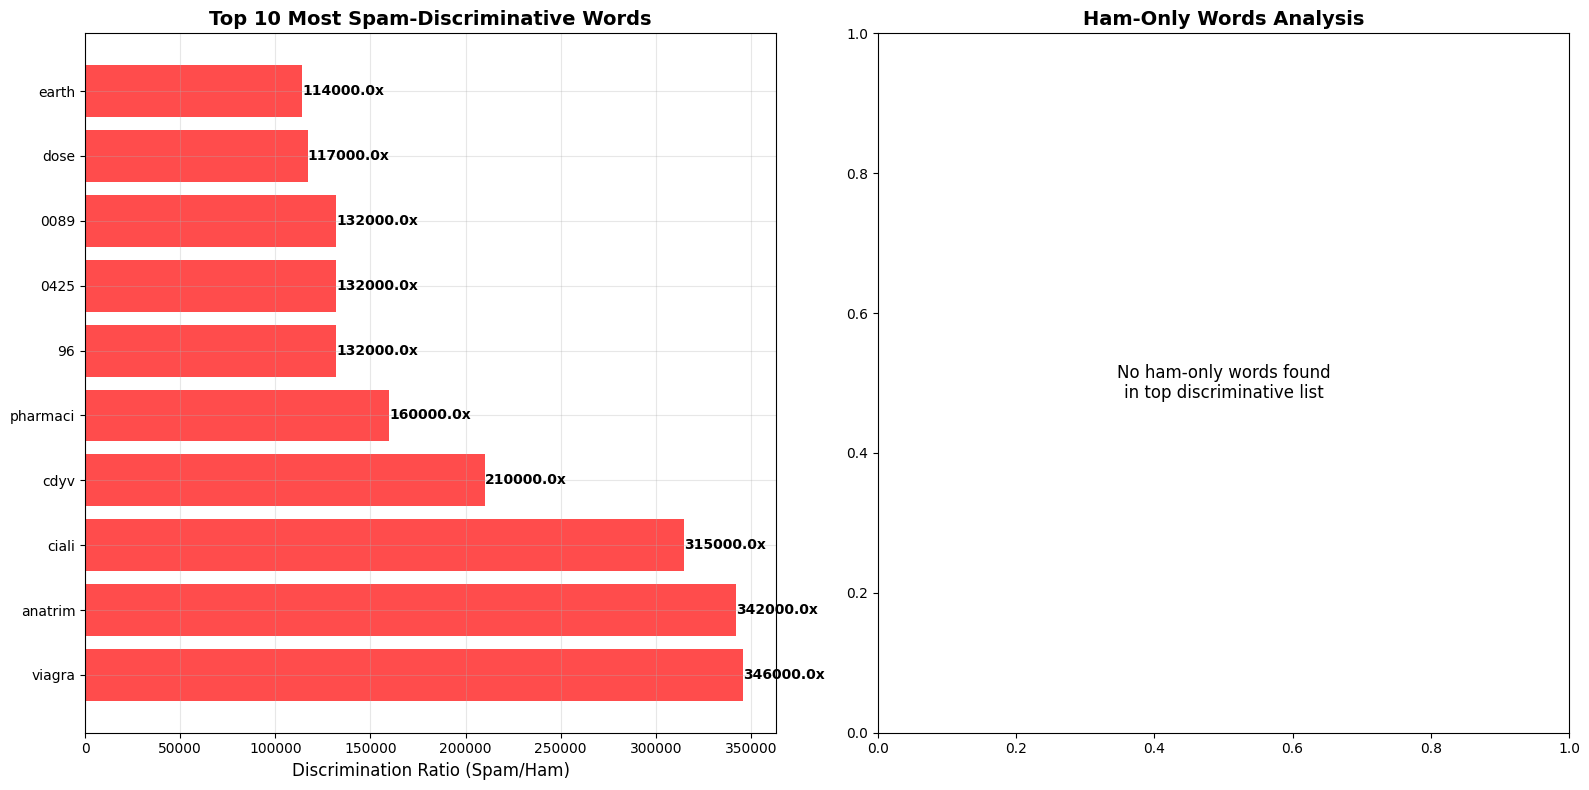


DISCRIMINATIVE WORDS ANALYSIS - KEY INSIGHTS

 🔴 MOST SPAM-DISCRIMINATIVE WORDS:
--------------------------------------------------
 1. viagra          | Ratio: 346000.0x | Spam: 346 | Ham:   0
 2. anatrim         | Ratio: 342000.0x | Spam: 342 | Ham:   0
 3. ciali           | Ratio: 315000.0x | Spam: 315 | Ham:   0
 4. cdyv            | Ratio: 210000.0x | Spam: 210 | Ham:   0
 5. pharmaci        | Ratio: 160000.0x | Spam: 160 | Ham:   0
 6. 96              | Ratio: 132000.0x | Spam: 132 | Ham:   0
 7. 0425            | Ratio: 132000.0x | Spam: 132 | Ham:   0
 8. 0089            | Ratio: 132000.0x | Spam: 132 | Ham:   0
 9. dose            | Ratio: 117000.0x | Spam: 117 | Ham:   0
10. earth           | Ratio: 114000.0x | Spam: 114 | Ham:   0

 🟢 HAM-ONLY WORDS (Anti-Spam Indicators):
--------------------------------------------------
   No significant ham-only words found in top features

 BUSINESS INSIGHTS:
--------------------------------------------------
• Word 'viagra' appears 34

In [36]:
# DISCRIMINATIVE WORDS ANALYSIS
# Identify words that best distinguish spam from ham emails

def get_discriminative_words(matrix, labels, feature_names, n=20):
    """
    Calculate discrimination ratio for each word (spam_frequency / ham_frequency)
    Higher ratios indicate words more common in spam
    """
    # Get indices for each class
    spam_indices = [i for i, label in enumerate(labels) if label == 'spam']
    ham_indices = [i for i, label in enumerate(labels) if label == 'ham']
    
    # Calculate word frequencies for each class
    spam_counts = matrix[spam_indices].sum(axis=0).A1  # Convert to 1D array
    ham_counts = matrix[ham_indices].sum(axis=0).A1
    
    # Calculate discrimination ratio (avoid division by zero)
    discrimination_ratio = np.where(ham_counts > 0, spam_counts / ham_counts, spam_counts * 1000)
    
    # Get top discriminative words
    top_indices = np.argsort(discrimination_ratio)[-n:][::-1]
    
    results = []
    for i in top_indices:
        if spam_counts[i] > 0:  # Only include words that appear in spam
            ratio = discrimination_ratio[i]
            spam_freq = spam_counts[i]
            ham_freq = ham_counts[i]
            results.append((feature_names[i], ratio, spam_freq, ham_freq))
    
    return results

# Get discriminative words
discriminative_words = get_discriminative_words(X_train, y_train, feature_names, n=15)

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Top discriminative words (most spam-biased)
word_names = [word for word, _, _, _ in discriminative_words[:10]]
ratios = [ratio for _, ratio, _, _ in discriminative_words[:10]]

bars = ax1.barh(range(len(word_names)), ratios, color='red', alpha=0.7)
ax1.set_yticks(range(len(word_names)))
ax1.set_yticklabels(word_names)
ax1.set_xlabel('Discrimination Ratio (Spam/Ham)', fontsize=12)
ax1.set_title('Top 10 Most Spam-Discriminative Words', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Add ratio values on bars
for i, (bar, ratio) in enumerate(zip(bars, ratios)):
    ax1.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{ratio:.1f}x', ha='left', va='center', fontweight='bold')

# Words that appear only in ham (anti-spam indicators)
ham_only_words = []
for i, (word, ratio, spam_freq, ham_freq) in enumerate(discriminative_words):
    if ham_freq > 0 and spam_freq == 0:
        ham_only_words.append((word, ham_freq))

# Sort by frequency and take top 10
ham_only_words.sort(key=lambda x: x[1], reverse=True)
ham_only_words = ham_only_words[:10]

if ham_only_words:
    ham_word_names = [word for word, _ in ham_only_words]
    ham_frequencies = [freq for _, freq in ham_only_words]
    
    bars2 = ax2.barh(range(len(ham_word_names)), ham_frequencies, color='green', alpha=0.7)
    ax2.set_yticks(range(len(ham_word_names)))
    ax2.set_yticklabels(ham_word_names)
    ax2.set_xlabel('Frequency in Ham Emails', fontsize=12)
    ax2.set_title('Top 10 Ham-Only Words (Anti-Spam Indicators)', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
else:
    ax2.text(0.5, 0.5, 'No ham-only words found\nin top discriminative list', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Ham-Only Words Analysis', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed insights
print("\n" + "="*70)
print("DISCRIMINATIVE WORDS ANALYSIS - KEY INSIGHTS")
print("="*70)

print("\n 🔴 MOST SPAM-DISCRIMINATIVE WORDS:")
print("-" * 50)
for i, (word, ratio, spam_freq, ham_freq) in enumerate(discriminative_words[:10], 1):
    print(f"{i:2d}. {word:<15} | Ratio: {ratio:6.1f}x | Spam: {spam_freq:3d} | Ham: {ham_freq:3d}")

print("\n 🟢 HAM-ONLY WORDS (Anti-Spam Indicators):")
print("-" * 50)
if ham_only_words:
    for i, (word, freq) in enumerate(ham_only_words[:10], 1):
        print(f"{i:2d}. {word:<15} | Frequency: {freq:3d}")
else:
    print("   No significant ham-only words found in top features")

# Business insights
print("\n BUSINESS INSIGHTS:")
print("-" * 50)
top_spam_word, top_ratio, _, _ = discriminative_words[0]
print(f"• Word '{top_spam_word}' appears {top_ratio:.1f}x more in spam than ham")
print(f"• {len([w for w, _, s, h in discriminative_words if s > 0 and h == 0])} words appear ONLY in spam")
print(f"• {len([w for w, _, s, h in discriminative_words if s == 0 and h > 0])} words appear ONLY in ham")

# ML implications
print("\n MACHINE LEARNING IMPLICATIONS:")
print("-" * 50)
print("• High-ratio words should have higher feature weights")
print("• Spam-only words can be used as strong spam indicators")
print("• Ham-only words can be used as strong legitimate email indicators")
print("• Consider creating binary features for top discriminative words")


**DataFrame explanation:**  
- Each **row** represents a single email.  
- Each **column** represents a unique word found across all emails.  
- The values are **1** if the word appears in the email, **0** otherwise.  
This allows you to see the presence or absence of each word in every email.

##### Preprocesamiento de los correos con el vectorizador creado anteriormente

## 7.- Preprocessing Pipeline Summary

In this project, we demonstrated **comprehensive data preprocessing techniques** for text classification using email data. The main preprocessing steps included:

1. **Data Selection:**  
   We used the 2007 TREC Public Spam Corpus, consisting of over 75,000 emails labeled as spam or ham.  

2. **HTML Content Cleaning:**  
   - Implemented custom `MLStripper` class to remove HTML tags.  
   - Handled both plain text and HTML email formats.  
   - Preserved only meaningful text content.  

3. **Text Preprocessing Pipeline:**  
   - **Punctuation removal** to clean text from unnecessary symbols.  
   - **Stopwords filtering** to remove common, uninformative words.  
   - **Stemming** using Porter Stemmer to reduce words to their root forms.  
   - **Tokenization** to split emails into individual words.  

4. **Text Vectorization:**  
   - Used `CountVectorizer` to transform preprocessed text into numerical features.  
   - Created Bag-of-Words representation suitable for machine learning algorithms.  
   - Generated document-term matrix with 20,890 unique features from 1,000 emails.  

5. **Data Structure Preparation:**  
   - Organized emails into structured format (subject + body).  
   - Maintained label associations for supervised learning.  
   - Prepared numerical feature matrix ready for ML algorithms.  

**Next Steps:** This preprocessed data is now ready for machine learning algorithms such as Logistic Regression, Naive Bayes, Random Forest, or Support Vector Machines for email classification tasks.

**Portfolio Integration:** The clean, vectorized dataset prepared in this preprocessing pipeline will be utilized in separate machine learning projects within the Machine Learning section of this portfolio to demonstrate different classification approaches and compare algorithm performance on the same preprocessed data.  




### Advanced Analysis Summary

In addition to the core preprocessing pipeline, this project includes **advanced exploratory data analysis** that provides deeper insights into the email data characteristics:

#### **Key Analytical Insights:**
- **Discriminative Words**: Identified specific vocabulary that strongly distinguishes spam from legitimate emails
- **Spam Pattern Categorization**: Classified different types of spam campaigns (financial, medical, promotional)
- **Language Complexity Analysis**: Analyzed sophistication differences between spam and legitimate email language

#### **Business Value:**
These analyses provide actionable insights for:
- **Feature Engineering**: Creating targeted features based on discriminative words and patterns
- **Model Optimization**: Understanding data characteristics to select appropriate ML algorithms
- **Spam Detection Rules**: Developing pattern-based filtering rules for real-world applications

#### **Machine Learning Implications:**
The advanced analysis enables:
- **Weighted Features**: Prioritizing high-discrimination words in classification models
- **Pattern-Based Features**: Creating composite features for different spam types
- **Complexity Thresholds**: Using language sophistication as a classification criterion
